In [1]:
import sys,os
sys.path.append(os.getcwd())

import gymnasium as gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from utils.vev_env import create_vecenv
from utils.utils import all_seed, plot_rewards, plot_losses

## 定义模型

In [2]:
def init_linear_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)

class Model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, std=0.0):
        super(Model, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            # nn.Linear(hidden_dim, hidden_dim),
            # nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            # nn.Linear(hidden_dim, hidden_dim),
            # nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )
        self.log_std = nn.Parameter(torch.ones(1, output_dim) * std)
        
        # self.apply(init_linear_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu = self.actor(x)
        mu = torch.tanh(mu)
        std = self.log_std.exp().expand_as(mu)
        return mu, std, value
    

    def save(self, path):
        torch.save(self.state_dict(), path)
    def load(self, path):
        self.load_state_dict(torch.load(path))

In [3]:
class Policy:
    def __init__(self, cfg):
        self.model = Model(cfg.state_dim, cfg.action_dim, cfg.hidden_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=cfg.lr)
        self.device = torch.device(cfg.device)
        self.action_scale = (cfg.action_space.high[0] - cfg.action_space.low[0]) / 2
        self.action_bias = (cfg.action_space.high[0] + cfg.action_space.low[0]) / 2
        self.n_epochs = cfg.n_epochs
        self.mini_batch_size = cfg.mini_batch_size
        self.clip_param = cfg.clip_param
        self.gamma = cfg.gamma
        self.tau = cfg.tau
        
    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float, device=self.device)
        mu, std, value = self.model(state)
        mu = mu * self.action_scale + self.action_bias
        dist = Normal(mu, std)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.cpu().numpy(), log_prob, value
    
    @staticmethod
    def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.size(0)
        for _ in range(batch_size // mini_batch_size):
            rand_ids = np.random.randint(0, batch_size, mini_batch_size)
            yield states[rand_ids, :], actions[rand_ids, :], log_probs[rand_ids, :], returns[rand_ids, :], advantage[rand_ids, :]
            
    def compute_return_mc(self, rewards, masks):
        returns = []
        discounted_return = 0
        for step in reversed(range(len(rewards))):
            discounted_return = rewards[step] + self.gamma * discounted_return * masks[step]
            returns.insert(0, discounted_return)
        # normalize can help to stabilize training
        normed_returns = []
        for ret in returns:
            normed_returns.append((ret - ret.mean()) / (ret.std() + 1e-5))
        return normed_returns
         
    def compute_advantage_td(self, rewards, masks, values):
        returns = []
        discounted_return = values[-1].detach()
        for step in reversed(range(len(rewards))):
            discounted_return = rewards[step] + self.gamma * discounted_return * masks[step]
            returns.insert(0, discounted_return)
        normed_returns = []
        for ret in returns:
            normed_returns.append((ret - ret.mean()) / (ret.std() + 1e-5))
        return normed_returns

    def compute_advantage_gae(self, next_value, rewards, masks, values):
        # next_value = values[-1]
        gae = 0
        returns = []
        for step in reversed(range(len(rewards))):
            delta = rewards[step] + self.gamma * next_value * masks[step] - values[step]
            gae = delta + self.gamma * self.tau * masks[step] * gae
            returns.insert(0, gae + values[step])
            next_value = values[step]
        normed_returns = []
        for ret in returns:
            normed_returns.append((ret - ret.mean()) / (ret.std() + 1e-5))
        return normed_returns
    
    def learn(self, **kwargs):
        states, actions, log_probs, returns, advantages = kwargs['states'], kwargs['actions'], kwargs['log_probs'], kwargs['returns'], kwargs['advantages']
        actor_loss_epoch, critic_loss_epoch = [], []
        for _ in range(self.n_epochs):
            for state, action, old_log_probs, return_, advantage in self.ppo_iter(self.mini_batch_size, states, actions, log_probs, returns, advantages):
                mu, std, value = self.model(state)
                mu = mu * self.action_scale + self.action_bias
                dist = Normal(mu, std)
                entropy = dist.entropy().mean()
                new_log_probs = dist.log_prob(action)

                ratio = (new_log_probs - old_log_probs).exp()
                surr1 = ratio * advantage
                surr2 = torch.clamp(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param) * advantage

                actor_loss  = - torch.min(surr1, surr2).mean()
                critic_loss = (return_ - value).pow(2).mean()

                actor_loss_epoch.append(actor_loss.item())
                critic_loss_epoch.append(critic_loss.item())

                loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy
                
                self.optimizer.zero_grad()
                loss.backward()
                for param in self.model.parameters():
                    param.grad.data.clamp_(-1, 1)
                self.optimizer.step()
        return np.mean(actor_loss_epoch), np.mean(critic_loss_epoch) 
        

In [4]:

def evaluate_policy(env, policy, vis=False):
    state,_ = env.reset()
    if vis: env.render()
    terminated = False
    total_reward = 0
    while True:
        action, _, _ = policy.get_action(np.array(state).reshape(1, -1))
        next_state, reward, terminated, truncated , _ = env.step(action[0])
        state = next_state
        # if vis: env.render()
        total_reward += reward
        if truncated:
            break
    
    return total_reward

In [5]:
class Config:
    def __init__(self):
        self.env_name = "Pendulum-v1"
        self.n_envs = 10
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.max_frames = 1000000
        self.seed = 1
        self.hidden_dim = 256
        self.lr = 3e-4
        self.n_steps = 200
        self.mini_batch_size = 50
        self.n_epochs = 4
        self.threshold_reward = -200
        self.clip_param = 0.2
        self.gamma = 0.95
        self.tau = 0.95
        

## 两种advantage的对比

计算advantage的通常有两种方式，如下：
1. 蒙特卡洛计算，returns - values，即$A(s,a) = G_t - V(s)$
2. TD error，即$A(s,a) = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$，或者GAE的形式，即$A(s,a) = \sum_{l=0}^{\infty}(\gamma \lambda)^l \delta_{t+l}^{V}$

这两种方式的对比如下：
1. 前者即MC的方式，是无偏估计，但是方差较大，因为returns是一个随机变量，而values是一个确定的值，所以两者相减会增大方差，后者是有偏估计，但是方差较小，因为TD error是一个确定的值，所以方差较小
2. 前者计算简单，后者计算复杂，因为后者需要计算TD error，而TD error需要计算V(s)，所以需要一个额外的网络来计算V(s)
3. 前者适合离散动作，后者适合连续动作，因为前者需要计算returns，而returns是一个随机变量，所以需要多次采样，而后者只需要计算TD error，所以只需要一次采样
4. 前者适合需要完整的序列，后者适合需要连续更新并降低方差以加速训练的情况，例如PPO等


### MC计算advantage效果


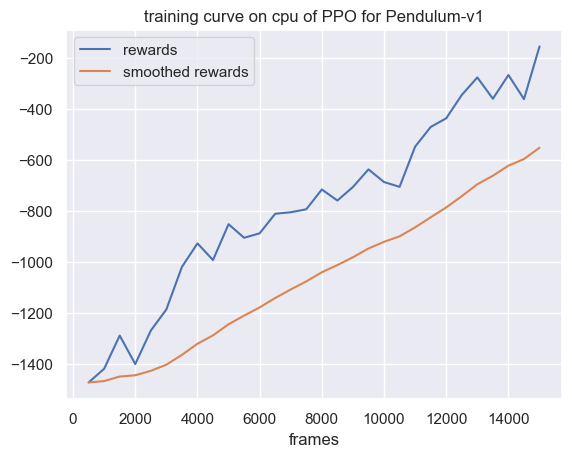

In [6]:
cfg = Config()
all_seed(cfg.seed)
env = create_vecenv(cfg.env_name, n_envs = cfg.n_envs)
test_env = gym.make(cfg.env_name)
setattr(cfg, "action_space", test_env.action_space)
setattr(cfg, "state_dim", env.observation_space.shape[0])
setattr(cfg, "action_dim", env.action_space.shape[0])
policy = Policy(cfg)

frame_idx  = 0
test_rewards = []
test_frames = []
update_steps = []
update_idx = 0
actor_losses = []
critic_losses = []
state = env.reset()
early_stop = False

while frame_idx < cfg.max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(cfg.n_steps):
        action, log_prob, value = policy.get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(cfg.device))
        masks.append(torch.FloatTensor(1 - truncated).unsqueeze(1).to(cfg.device))
        
        states.append(torch.tensor(state, dtype=torch.float, device=cfg.device))
        actions.append(torch.tensor(action, dtype=torch.float, device=cfg.device))
        
        state = next_state
        frame_idx += 1
        if frame_idx % 500 == 0:
            test_reward = np.mean([evaluate_policy(test_env, policy) for _ in range(10)])
            test_rewards.append(test_reward)
            test_frames.append(frame_idx)
            # print(f"Frame {frame_idx}. Mean reward: {test_reward}")
            plot_rewards(test_frames, test_rewards, device = cfg.device)
            if test_reward > cfg.threshold_reward: early_stop = True
        
    next_state = torch.FloatTensor(next_state).to(cfg.device)
    _, _, next_value = policy.model(next_state)
    returns = policy.compute_return_mc(rewards, masks)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states) 
    actions   = torch.cat(actions)
    advantage = returns - values
    actor_loss, critic_loss = policy.learn(states=states, actions=actions, log_probs=log_probs, returns=returns, advantages=advantage)
    update_idx += 1
    update_steps.append(update_idx)
    actor_losses.append(actor_loss)
    critic_losses.append(critic_loss)

env.close()
test_env.close()

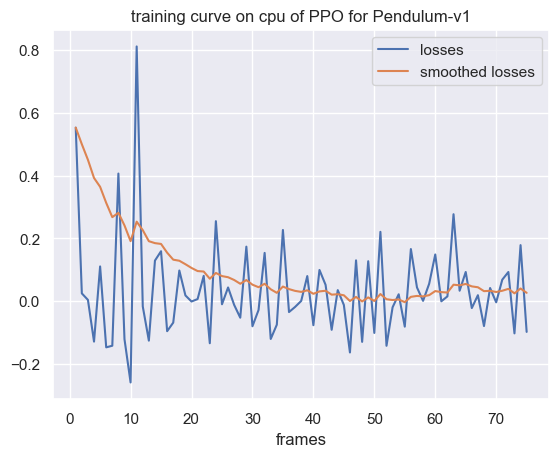

In [7]:
plot_losses(update_steps, actor_losses, cfg.device)

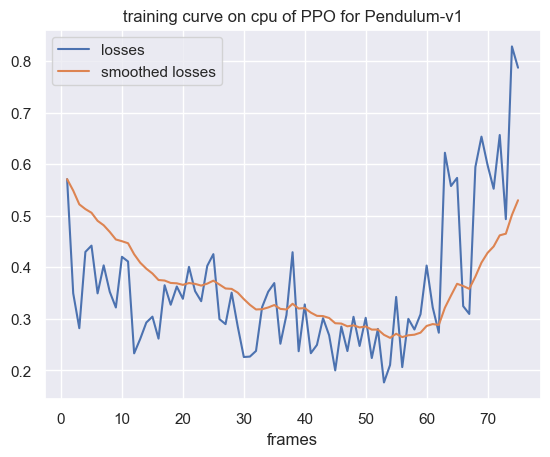

In [8]:
plot_losses(update_steps, critic_losses, cfg.device)

## TD计算advantage的效果

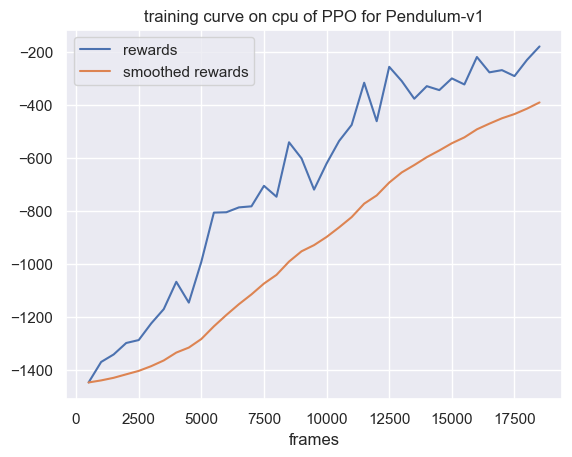

In [9]:
cfg = Config()
all_seed(cfg.seed)
env = create_vecenv(cfg.env_name, n_envs = cfg.n_envs)
test_env = gym.make(cfg.env_name)
setattr(cfg, "action_space", test_env.action_space)
setattr(cfg, "state_dim", env.observation_space.shape[0])
setattr(cfg, "action_dim", env.action_space.shape[0])
policy = Policy(cfg)

frame_idx  = 0
test_rewards = []
test_frames = []
update_steps = []
update_idx = 0
actor_losses = []
critic_losses = []
state = env.reset()
early_stop = False

while frame_idx < cfg.max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(cfg.n_steps):
        action, log_prob, value = policy.get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(cfg.device))
        masks.append(torch.FloatTensor(1 - truncated).unsqueeze(1).to(cfg.device))
        
        states.append(torch.tensor(state, dtype=torch.float, device=cfg.device))
        actions.append(torch.tensor(action, dtype=torch.float, device=cfg.device))
        
        state = next_state
        frame_idx += 1
        if frame_idx % 500 == 0:
            test_reward = np.mean([evaluate_policy(test_env, policy) for _ in range(10)])
            test_rewards.append(test_reward)
            test_frames.append(frame_idx)
            # print(f"Frame {frame_idx}. Mean reward: {test_reward}")
            plot_rewards(test_frames, test_rewards, device = cfg.device)
            if test_reward > cfg.threshold_reward: early_stop = True
        
    next_state = torch.FloatTensor(next_state).to(cfg.device)
    _, _, next_value = policy.model(next_state)
    returns = policy.compute_advantage_td(rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states) 
    actions   = torch.cat(actions)
    advantage = returns - values
    actor_loss, critic_loss = policy.learn(states=states, actions=actions, log_probs=log_probs, returns=returns, advantages=advantage)
    update_idx += 1
    update_steps.append(update_idx)
    actor_losses.append(actor_loss)
    critic_losses.append(critic_loss)
env.close()
test_env.close()

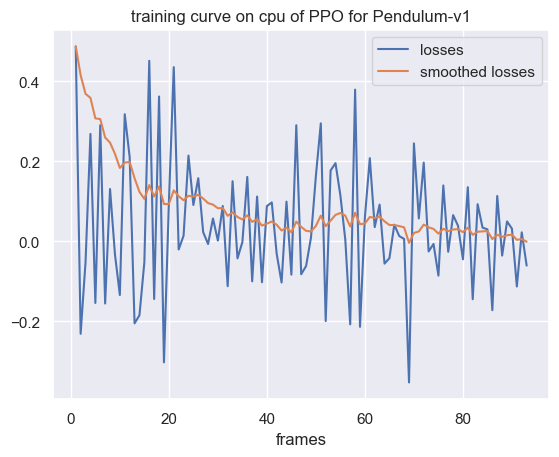

In [10]:
plot_losses(update_steps, actor_losses, cfg.device)

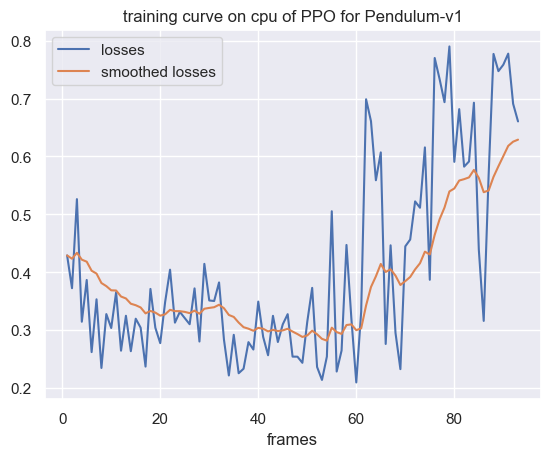

In [11]:
plot_losses(update_steps, critic_losses, cfg.device)

### GAE计算advantage效果


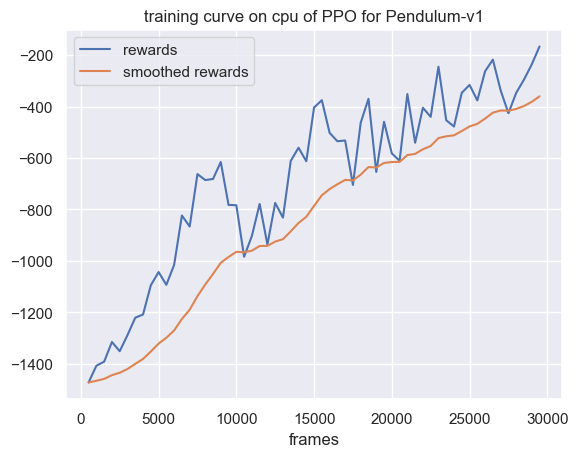

In [12]:
cfg = Config()
all_seed(cfg.seed)
env = create_vecenv(cfg.env_name, n_envs = cfg.n_envs)
test_env = gym.make(cfg.env_name)
setattr(cfg, "action_space", test_env.action_space)
setattr(cfg, "state_dim", env.observation_space.shape[0])
setattr(cfg, "action_dim", env.action_space.shape[0])
policy = Policy(cfg)

frame_idx  = 0
test_rewards = []
test_frames = []
update_steps = []
update_idx = 0
actor_losses = []
critic_losses = []
state = env.reset()
early_stop = False

while frame_idx < cfg.max_frames and not early_stop:

    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0

    for _ in range(cfg.n_steps):
        action, log_prob, value = policy.get_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(cfg.device))
        masks.append(torch.FloatTensor(1 - truncated).unsqueeze(1).to(cfg.device))
        
        states.append(torch.tensor(state, dtype=torch.float, device=cfg.device))
        actions.append(torch.tensor(action, dtype=torch.float, device=cfg.device))
        
        state = next_state
        frame_idx += 1
        if frame_idx % 500 == 0:
            test_reward = np.mean([evaluate_policy(test_env, policy) for _ in range(10)])
            test_rewards.append(test_reward)
            test_frames.append(frame_idx)
            # print(f"Frame {frame_idx}. Mean reward: {test_reward}")
            plot_rewards(test_frames, test_rewards, device = cfg.device)
            if test_reward > cfg.threshold_reward: early_stop = True
        
    next_state = torch.FloatTensor(next_state).to(cfg.device)
    _, _, next_value = policy.model(next_state)
    # returns = policy.compute_monte_carlo_advantage(rewards, masks, values)
    returns = policy.compute_advantage_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.cat(states) 
    actions   = torch.cat(actions)
    advantage = returns - values
    actor_loss, critic_loss = policy.learn(states=states, actions=actions, log_probs=log_probs, returns=returns, advantages=advantage)
    update_idx += 1
    update_steps.append(update_idx)
    actor_losses.append(actor_loss)
    critic_losses.append(critic_loss)
env.close()
test_env.close()

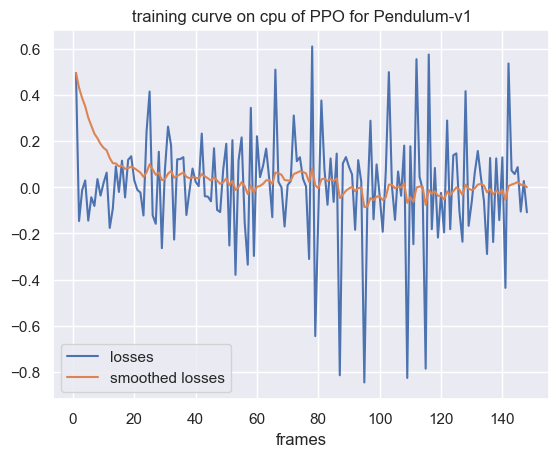

In [13]:
plot_losses(update_steps, actor_losses, cfg.device)

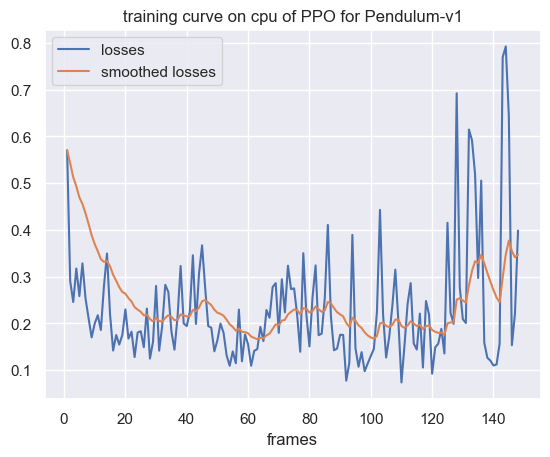

In [14]:
plot_losses(update_steps, critic_losses, cfg.device)